## **사용자 군집화 방식_최종**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'NanumSquare'

In [ ]:
users = pd.read_csv('/content/drive/MyDrive/DXSCHOOL/Project/data_final/db_userinfo.csv')
vods = pd.read_csv('/content/drive/MyDrive/DXSCHOOL/Project/data_final/db_vods_sumut.csv',dtype={'program_id':str})
conts = pd.read_csv('/content/drive/MyDrive/DXSCHOOL/Project/data_final/db_contlog.csv',dtype={'program_id':str})
program_info_all = pd.read_csv('/content/drive/MyDrive/DXSCHOOL/Project/data_final/db_vodinfo.csv',dtype={'program_id':str})

In [ ]:
# e_bool == 0 인 데이터만 뽑기
vod_log = vods[vods['e_bool']==0][['subsr_id', 'program_id', 'program_name', 'episode_num', 'log_dt', 'use_tms', 'disp_rtm_sec', 'count_watch', 'month', 'day', 'age_limit']]
cont_log = conts[conts['e_bool']==0][['subsr_id', 'program_id', 'program_name', 'episode_num', 'log_dt', 'month', 'day', 'age_limit']]
vod_info = program_info_all[program_info_all['e_bool']==0][['program_id','program_name', 'ct_cl', 'program_genre', 'release_date', 'age_limit']]
user_info = users.copy()

#### **User별 군집 설정**

In [ ]:
user_type = users.copy()
vod_log_89 = vod_log[vod_log['month'].isin([8,9])]

# 사용자별 상세보기 vod수
user_type = user_type.merge(cont_log.groupby(['subsr_id', 'program_id']).count()[['program_name']].groupby('subsr_id').count().reset_index().rename(columns={'program_name':'상세보기vod수'}), how='left')

# 사용자별 시청 vod수
user_type = user_type.merge(vod_log_89.groupby(['subsr_id', 'program_id']).count()[['program_name']].groupby('subsr_id').count().reset_index().rename(columns={'program_name':'시청vod수'}), how='left')

# 사용자별 방문빈도수 (day기반)
user_type = user_type.merge(cont_log.groupby(['subsr_id','month', 'day']).count()[['program_id']].groupby(['subsr_id', 'month']).count().groupby('subsr_id').sum([['program_id']]).reset_index().rename(columns={'program_id':'방문빈도수'}), how='left')

# 사용자별 상세보기조회빈도(클릭수)
user_type = user_type.merge(cont_log.groupby(['subsr_id']).count()[['program_id']].reset_index().rename(columns={'program_id':'상세보기조회빈도(클릭수)'}), how='left')

# 사용자별 평균 클릭수 (클릭수 / 방문빈도수)
user_type['평균 클릭수'] = user_type['상세보기조회빈도(클릭수)'] / user_type['방문빈도수']

# 사용자별 시청빈도(시청수)
user_type = user_type.merge(vod_log_89.groupby(['subsr_id']).count()[['program_id']].reset_index().rename(columns={'program_id':'시청빈도(시청수)'}), how='left')

# 사용자별 평균 시청수 (시청수 / 방문빈도수)
user_type['평균 시청수'] = user_type['시청빈도(시청수)'] / user_type['방문빈도수']

# 사용자별 시청시간합계 (use_ts)
user_type = user_type.merge(vod_log_89.groupby(['subsr_id']).sum()[['use_tms']].reset_index().rename(columns={'use_tms':'시청시간합계'}), how='left')

# 사용자별 평균 시청시간 (시청시가합계 / 방문빈도수)
user_type['평균 시청시간'] = user_type['시청시간합계'] / user_type['방문빈도수']

# 사용자별 vod 시청 비율 (완전한 시청에 대한 기준?)
vod_log_89['use_tms_ratio'] = vod_log_89['use_tms'] / vod_log_89['disp_rtm_sec']
user_type = user_type.merge(vod_log_89.groupby(['subsr_id']).mean()[['use_tms_ratio']].reset_index().rename(columns={'use_tms_ratio':'vod평균시청율'}), how='left')

# 시청전환율
user_type['시청전환율'] = user_type['시청vod수'] / user_type['상세보기vod수']

# age_limit (청불 시청 여부) - 근데 이건 부정확할 수 있음
# 근데, 둘다 1이라면, 분리가 필요하다고 말할 수 있을 듯!
user_type.loc[user_type[user_type['subsr_id'].isin(cont_log[cont_log['age_limit']=='청불']['subsr_id'].unique())].index, '청불여부_상세보기'] = 1
user_type['청불여부_상세보기'] = user_type['청불여부_상세보기'].fillna(0)

user_type.loc[user_type[user_type['subsr_id'].isin(vod_log_89[vod_log_89['age_limit']=='청불']['subsr_id'].unique())].index, '청불여부_시청'] = 1
user_type['청불여부_시청'] = user_type['청불여부_시청'].fillna(0)


In [ ]:
#user_type

# 1) ColdStart_user: 8,9월 기준 어떤 기록도 없는 유저 == 0
user_type.loc[user_type[(user_type['상세보기vod수'].isnull()) & (user_type['시청vod수'].isnull())].index, 'user_type'] = 0

# 2) Starter_user: 8,9월 기준 시청빈도 25% 이하 == 1
user_type.loc[user_type[(user_type['user_type'].isnull()) & (user_type['시청빈도(시청수)'] <= user_type['시청빈도(시청수)'].quantile(0.4))].index, 'user_type'] = 1

# 4) Heavy_user: 8,9월 기준 시청빈도 75% 이상 (상위25%) == 3
user_type.loc[user_type[(user_type['user_type'].isnull()) & (user_type['시청빈도(시청수)'] >= user_type['시청빈도(시청수)'].quantile(0.6))].index, 'user_type'] = 3

# 3) Standard_user == 2 (나머지이므로 마지막에 남은거 할당!)
user_type.loc[user_type[user_type['user_type'].isnull()].index, 'user_type'] = 2

In [ ]:
user_type['user_type'].value_counts()

2.0    557
1.0    188
3.0    178
0.0     28
Name: user_type, dtype: int64

## **군집별 모델 비교 방식**

### **개인화 추천모델**
**[LightFM ver2]** -> 장르 포함 (변경이전)
- **precision** : 0.025
- **Recall** : 0.13620162079983508
- **mAP@k** : 0.039179244614512464
- **mAR@k** : 0.10545671399572334


**[현재평가지표]**
- **Precision@k** : 우리가 추천한 아이템 K개 중에 사용자가 관심있는 아이템의 비율
- **Recall@k** : 실제로 사용자가 관심있어하는 아이템 중에 우리가 추천한 아이템의 비율
- **MAP@k** : 점수 순위 문제를 고려,모든 유저에 대한 평가, Ranking 문제의 평가지표로 활용됨
잘못된 예측은 패널티를 받으며, 같은 예측이더라도 올바른 예측이 우선적으로 보여지는 지를 판단함.
- **MAR@k** : 모든 사용자에 대한 평균 Recall, 여러 사용자에 대한 평균을 포함한 평가지표


**[추천시스템에서의 성능]**
- 추천 시스템의 성능은 2가지 관점에서 가능
서비스 관점, 추천 시스템의 품질 관점

- 추천 시스템 품질 관점
단순히 클릭률과 정확도 뿐만 아니라 다양성을 고려
- **다양성** : 선호와 취향에 따른 추천 결과만 받게 된다면 취향에 갇히게 되어 굴극적으로 사용자의 만족도를 하락시킴 **<필터버블>**
  - 이를 해결하기 위하여, 다양성을 평가지표로 포함하고, **<재추천>**기능을 통해 추천 결과에 대한 품질을 높이고자 함.

-------------

### **User info 데이터 생성과정**

In [ ]:
# 파일 추가 전처리 부분
import numpy as np
import pandas as pd

# 이부분 경로 바꾸기
users = pd.read_csv('/content/drive/MyDrive/dxdata/users.csv')
conts = pd.read_csv('/content/drive/MyDrive/dxdata/conts.csv', dtype={'program_id':str})
vods = pd.read_csv('/content/drive/MyDrive/dxdata/vods_sumut.csv', dtype={'program_id':str})
program_info_all = pd.read_csv('/content/drive/MyDrive/dxdata/program_info_all.csv', dtype={'program_id':str})

vods_sumut = pd.read_csv('/content/drive/MyDrive/dxdata/vods_sumut.csv', dtype={'program_id':str}) # vod 로그 기록 - subsr, program_id, 날짜 기준으로 중복 데이터 합친 것 (모델링용으로 추천함)

In [ ]:
vods_sumut['week'] = pd.to_datetime(vods_sumut['log_dt']).dt.week
conts['week'] = pd.to_datetime(conts['log_dt']).dt.week

<ipython-input-78-64eb1b567243>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  vods_sumut['week'] = pd.to_datetime(vods_sumut['log_dt']).dt.week
<ipython-input-78-64eb1b567243>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  conts['week'] = pd.to_datetime(conts['log_dt']).dt.week


In [ ]:
vods_sumut['log_dt'] = pd.to_datetime(vods_sumut['log_dt'])
conts['log_dt'] = pd.to_datetime(conts['log_dt'])

In [ ]:
# 휴일여부
vods_sumut.loc[vods_sumut[vods_sumut['log_dt'].dt.strftime('%Y-%m-%d') == '2023-09-28'].index, 'isholiday'] = 1
vods_sumut.loc[vods_sumut[vods_sumut['log_dt'].dt.strftime('%Y-%m-%d') == '2023-09-29'].index, 'isholiday'] = 1
vods_sumut.loc[vods_sumut[vods_sumut['log_dt'].dt.strftime('%Y-%m-%d') == '2023-09-30'].index, 'isholiday'] = 1
vods_sumut.loc[vods_sumut[vods_sumut['log_dt'].dt.strftime('%Y-%m-%d') == '2023-08-15'].index, 'isholiday'] = 1

In [ ]:
conts.loc[conts[conts['log_dt'].dt.strftime('%Y-%m-%d') == '2023-09-28'].index, 'isholiday'] = 1
conts.loc[conts[conts['log_dt'].dt.strftime('%Y-%m-%d') == '2023-09-29'].index, 'isholiday'] = 1
conts.loc[conts[conts['log_dt'].dt.strftime('%Y-%m-%d') == '2023-09-30'].index, 'isholiday'] = 1
conts.loc[conts[conts['log_dt'].dt.strftime('%Y-%m-%d') == '2023-08-15'].index, 'isholiday'] = 1

In [ ]:
conts['isholiday'] = conts['isholiday'].fillna(0)
vods_sumut['isholiday'] = vods_sumut['isholiday'].fillna(0)

In [ ]:
# 주중 / 주말 여부
vods_sumut.loc[vods_sumut[vods_sumut['day_name'].isin(['Saturday', 'Sunday'])].index, 'isweekend'] = 1
conts.loc[conts[conts['day_name'].isin(['Saturday', 'Sunday'])].index, 'isweekend'] = 1
vods_sumut['isweekend'] = vods_sumut['isweekend'].fillna(0)
conts['isweekend'] = conts['isweekend'].fillna(0)

In [ ]:
vod_log = vods_sumut[vods_sumut['e_bool']==0][['subsr_id', 'program_id', 'program_name', 'episode_num', 'ct_cl', 'program_genre', 'log_dt', 'month', 'week', 'day', 'hour', 'minute', 'weekday', 'day_name', 'isholiday', 'isweekend', 'age_limit', 'use_tms', 'disp_rtm_sec', 'count_watch']]
cont_log = conts[conts['e_bool']==0][['subsr_id', 'program_id', 'program_name', 'episode_num', 'ct_cl', 'program_genre', 'log_dt', 'month', 'week', 'day', 'hour', 'minute', 'weekday', 'day_name', 'isholiday', 'isweekend', 'age_limit']]

In [ ]:
# vod_log.to_csv('./EDA/vod_log.csv', encoding='cp949')
# cont_log.to_csv('./EDA/cont_log.csv', encoding='cp949')

In [ ]:
# 월별 방문 user 수 (unique)
monthly = cont_log.groupby(['month', 'subsr_id']).count()[['program_id']].groupby('month').count().reset_index().rename(columns={'program_id':'방문user수'})
# 월별 시청 user수 (unique)
monthly = monthly.merge(vod_log.groupby(['month', 'subsr_id']).count()[['program_id']].groupby('month').count().reset_index().rename(columns={'program_id':'시청user수'}), how='left')
# 월별 방문수
monthly = monthly.merge(cont_log.groupby(['month']).count()[['program_id']].reset_index().rename(columns={'program_id':'상세보기조회수'}), how='left')
# 월별 시청수
monthly = monthly.merge(vod_log.groupby(['month']).count()[['program_id']].reset_index().rename(columns={'program_id':'시청수'}), how='left')

In [ ]:
# 주별 방문 user 수 (unique)
weekly = cont_log.groupby(['week', 'subsr_id']).count()[['program_id']].groupby('week').count().reset_index().rename(columns={'program_id':'방문user수'})
# 주별 시청 user수 (unique)
weekly = weekly.merge(vod_log.groupby(['week', 'subsr_id']).count()[['program_id']].groupby('week').count().reset_index().rename(columns={'program_id':'시청user수'}), how='left')
# 주별 상세보기 조회수
weekly = weekly.merge(cont_log.groupby(['week']).count()[['program_id']].reset_index().rename(columns={'program_id':'상세보기조회수'}), how='left')
# 주별 시청수
weekly = weekly.merge(vod_log.groupby(['week']).count()[['program_id']].reset_index().rename(columns={'program_id':'시청수'}), how='left')

In [ ]:
# weekly.to_csv('./weekly.csv')

In [ ]:
# 요일별 하루 평균 방문 user수 (unique)
daily = cont_log.groupby(['week', 'day_name', 'subsr_id']).count()[['program_id']].groupby(['week', 'day_name']).count().groupby('day_name').mean().reset_index().rename(columns={'program_id':'평균방문user수'})
# 요일별 하루 평균 시청user수 (unique)
daily = daily.merge(vod_log.groupby(['week','day_name', 'subsr_id']).count()[['program_id']].groupby(['week', 'day_name']).count().groupby('day_name').mean().reset_index().rename(columns={'program_id':'평균시청user수'}), how='left')
# 요일별 평균상세보기조회수
daily = daily.merge(cont_log.groupby(['week', 'day_name']).count()[['program_id']].groupby('day_name').mean().reset_index().rename(columns={'program_id':'평균상세보기조회수'}), how='left')
# 요일별 평균시청수
daily = daily.merge(vod_log.groupby(['week', 'day_name']).count()[['program_id']].groupby('day_name').mean().reset_index().rename(columns={'program_id':'평균시청수'}), how='left')

In [ ]:
# 시간대별 시간 평균 방문user수 (unique)
hourly = cont_log.groupby(['day','hour','subsr_id']).count()[['program_id']].groupby(['day','hour']).count().groupby('hour').mean().reset_index().rename(columns={'program_id':'평균방문user수'})
# 시간대별 시간 평균 시청user 수 (unique)
hourly = hourly.merge(vod_log.groupby(['day','hour','subsr_id']).count()[['program_id']].groupby(['day','hour']).count().groupby('hour').mean().reset_index().rename(columns={'program_id':'평균시청user수'}), how='left')
# 시간대별 시간 평균 상세보기조회수
hourly = hourly.merge(cont_log.groupby(['day', 'hour']).count()[['program_id']].groupby('hour').mean().reset_index().rename(columns={'program_id':'평균상세보기조회수'}), how='left')
# 시간대별 시간 평균 시청수
hourly = hourly.merge(vod_log.groupby(['day', 'hour']).count()[['program_id']].groupby('hour').mean().reset_index().rename(columns={'program_id':'평균시청수'}), how='left')

In [ ]:
# hourly.to_csv('./EDA/hourly.csv')
# hourly_주중.to_csv('./EDA/hourly_주중.csv')
# hourly_주말.to_csv('./EDA/hourly_주말.csv')

In [ ]:
# 주중
hourly_주중 = cont_log[cont_log['isweekend']==0].groupby(['day','hour','subsr_id']).count()[['program_id']].groupby(['day','hour']).count().groupby('hour').mean().reset_index().rename(columns={'program_id':'평균방문user수'})
hourly_주중 = hourly_주중.merge(vod_log[vod_log['isweekend']==0].groupby(['day','hour','subsr_id']).count()[['program_id']].groupby(['day','hour']).count().groupby('hour').mean().reset_index().rename(columns={'program_id':'평균시청user수'}), how='left')
hourly_주중 = hourly_주중.merge(cont_log[cont_log['isweekend']==0].groupby(['day', 'hour']).count()[['program_id']].groupby('hour').mean().reset_index().rename(columns={'program_id':'평균상세보기조회수'}), how='left')
hourly_주중 = hourly_주중.merge(vod_log[vod_log['isweekend']==0].groupby(['day', 'hour']).count()[['program_id']].groupby('hour').mean().reset_index().rename(columns={'program_id':'평균시청수'}), how='left')

In [ ]:
# 주말
hourly_주말 = cont_log[cont_log['isweekend']==1].groupby(['day','hour','subsr_id']).count()[['program_id']].groupby(['day','hour']).count().groupby('hour').mean().reset_index().rename(columns={'program_id':'평균방문user수'})
hourly_주말 = hourly_주말.merge(vod_log[vod_log['isweekend']==1].groupby(['day','hour','subsr_id']).count()[['program_id']].groupby(['day','hour']).count().groupby('hour').mean().reset_index().rename(columns={'program_id':'평균시청user수'}), how='left')
hourly_주말 = hourly_주말.merge(cont_log[cont_log['isweekend']==1].groupby(['day', 'hour']).count()[['program_id']].groupby('hour').mean().reset_index().rename(columns={'program_id':'평균상세보기조회수'}), how='left')
hourly_주말 = hourly_주말.merge(vod_log[vod_log['isweekend']==1].groupby(['day', 'hour']).count()[['program_id']].groupby('hour').mean().reset_index().rename(columns={'program_id':'평균시청수'}), how='left')

In [ ]:
hourly_주중.columns=['hour', '주중_평균방문user수', '주중_평균시청user수', '주중_평균상세보기조회수', '주중_평균시청수']
hourly_주말.columns=['hour', '주말_평균방문user수', '주말_평균시청user수', '주말_평균상세보기조회수', '주말_평균시청수']
hourly_주중.merge(hourly_주말, how='left')

,hour,주중_평균방문user수,주중_평균시청user수,주중_평균상세보기조회수,주중_평균시청수,주말_평균방문user수,주말_평균시청user수,주말_평균상세보기조회수,주말_평균시청수
0,0,7.774194,5.275862,18.645161,7.344828,5.764706,4.000000,22.411765,5.937500
1,1,6.193548,3.766667,27.419355,4.733333,4.352941,3.333333,14.529412,4.866667
2,2,4.700000,3.321429,32.533333,4.214286,3.470588,3.062500,12.352941,3.687500
3,3,4.419355,2.724138,22.290323,3.551724,3.117647,2.800000,16.588235,3.200000
4,4,4.516129,3.172414,32.903226,4.068966,4.400000,2.294118,11.133333,2.705882
5,5,4.200000,2.730769,18.166667,3.307692,3.733333,2.437500,7.733333,3.000000
6,6,5.250000,3.153846,27.035714,4.038462,3.437500,1.714286,8.937500,2.428571
7,7,5.600000,3.068966,20.000000,4.000000,5.000000,3.176471,15.411765,3.647059
8,8,6.935484,4.033333,23.129032,5.766667,6.647059,3.411765,14.529412,3.941176
9,9,7.774194,4.766667,19.548387,6.966667,6.823529,4.176471,16.176471,6.352941


사용자별

In [ ]:
user_type = users.copy()

In [ ]:
# 사용자별 상세보기 vod수
user_type = user_type.merge(cont_log.groupby(['subsr_id', 'program_id']).count()[['program_name']].groupby('subsr_id').count().reset_index().rename(columns={'program_name':'상세보기vod수'}), how='left')

# 사용자별 시청 vod수
user_type = user_type.merge(vod_log.groupby(['subsr_id', 'program_id']).count()[['program_name']].groupby('subsr_id').count().reset_index().rename(columns={'program_name':'시청vod수'}), how='left')

# 사용자별 주별 평균 시청 vod수
user_type = user_type.merge(vod_log.groupby(['subsr_id', 'week', 'program_id']).count()[['program_name']].groupby(['subsr_id', 'week']).count().groupby('subsr_id').mean().reset_index().rename(columns={'program_name':'주평균시청vod수'}), how='left')

# 사용자별 방문빈도수 (day기반)
user_type = user_type.merge(cont_log.groupby(['subsr_id','month', 'day']).count()[['program_id']].groupby(['subsr_id', 'month']).count().groupby('subsr_id').sum([['program_id']]).reset_index().rename(columns={'program_id':'방문빈도수'}), how='left')

# 사용자별 상세보기조회빈도(클릭수)
user_type = user_type.merge(cont_log.groupby(['subsr_id']).count()[['program_id']].reset_index().rename(columns={'program_id':'상세보기조회빈도(클릭수)'}), how='left')

# 사용자별 평균 클릭수 (클릭수 / 방문빈도수)
user_type['평균 클릭수'] = user_type['상세보기조회빈도(클릭수)'] / user_type['방문빈도수']

# 사용자별 시청빈도(시청수)
user_type = user_type.merge(vod_log.groupby(['subsr_id']).count()[['program_id']].reset_index().rename(columns={'program_id':'시청빈도(시청수)'}), how='left')

# 사용자별 평균 시청수 (시청수 / 방문빈도수)
user_type['평균 시청수'] = user_type['시청빈도(시청수)'] / user_type['방문빈도수']

# 사용자별 시청시간합계 (use_ts)
user_type = user_type.merge(vod_log.groupby(['subsr_id']).sum()[['use_tms']].reset_index().rename(columns={'use_tms':'시청시간합계'}), how='left')

# 사용자별 평균 시청시간 (시청시가합계 / 방문빈도수)
user_type['평균 시청시간'] = user_type['시청시간합계'] / user_type['방문빈도수']

# 사용자별 vod 시청 비율 (완전한 시청에 대한 기준?)
vod_log['use_tms_ratio'] = vod_log['use_tms'] / vod_log['disp_rtm_sec']
user_type = user_type.merge(vod_log.groupby(['subsr_id']).mean()[['use_tms_ratio']].reset_index().rename(columns={'use_tms_ratio':'vod평균시청율'}), how='left')

# 시청전환율
user_type['시청전환율'] = user_type['시청vod수'] / user_type['상세보기vod수']

# age_limit (청불 시청 여부) - 근데 이건 부정확할 수 있음
# 근데, 둘다 1이라면, 분리가 필요하다고 말할 수 있을 듯!
user_type.loc[user_type[user_type['subsr_id'].isin(cont_log[cont_log['age_limit']=='청불']['subsr_id'].unique())].index, '청불여부_상세보기'] = 1
user_type['청불여부_상세보기'] = user_type['청불여부_상세보기'].fillna(0)

user_type.loc[user_type[user_type['subsr_id'].isin(vod_log[vod_log['age_limit']=='청불']['subsr_id'].unique())].index, '청불여부_시청'] = 1
user_type['청불여부_시청'] = user_type['청불여부_시청'].fillna(0)

<ipython-input-96-47707ec6bf0c>:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  user_type = user_type.merge(vod_log.groupby(['subsr_id']).sum()[['use_tms']].reset_index().rename(columns={'use_tms':'시청시간합계'}), how='left')
<ipython-input-96-47707ec6bf0c>:33: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  user_type = user_type.merge(vod_log.groupby(['subsr_id']).mean()[['use_tms_ratio']].reset_index().rename(columns={'use_tms_ratio':'vod평균시청율'}), how='left')


In [ ]:
# user_type = pd.to_csv('/content/drive/MyDrive/dxdata/user_type.csv')

In [ ]:
# 타입 설정 (0: 시청기록 x, 1: 시청기록 o)

# 1) 시청목록 있는데 상세보기 없는 유저 - 22명 (이상치라고 했음)
user_type.loc[user_type[(user_type['시청vod수'].isnull())].index, 'user_type'] = 0
user_type['user_type'] = user_type['user_type'].fillna(1)

In [ ]:
user_type.loc[user_type[user_type['시청전환율']>1].index, '시청전환율'] = 1
user_type[user_type['user_type']==1][['시청전환율', '시청빈도(시청수)']].describe()
user_type # 전체 유저에 포함
# user_type.to_csv('/content/drive/MyDrive/dxdata/user_type.csv')

In [ ]:
# Heavy User 와 Cold Start User를 구분하는 기준: <시청빈도(시청수)> user_info2 #407명
# Beginner : 1) 시청목록 있는데 상세보기 없는 유저 - 22명
user_type['type_name'] = 0
user_type['type_num'] = 0
user_type['type_name'][user_type['user_type']==0] = "Beginner"

# Starter_user : 시청빈도 25% 이하
# => Cold Starter 와 분리할지 여부는 추후 확인
# user_type.loc[(user_type['user_type'] ==0) & (user_type['시청빈도(시청수)'] <= user_type['시청빈도(시청수)'].quantile(0.25)).index, 'type_name'] = "Beginner"

user_type.loc[(user_type['user_type'] ==1) & (user_type['시청빈도(시청수)'] <= user_type['시청빈도(시청수)'].quantile(0.25)).index, 'type_name'] = "Starter"
user_type.loc[(user_type['user_type'] ==1) & (user_type['시청빈도(시청수)'] <= user_type['시청빈도(시청수)'].quantile(0.25)).index, 'type_num'] = 1

# standard_user
user_type.loc[(user_type['user_type'] ==1) &
 (user_type['시청빈도(시청수)'] > user_type['시청빈도(시청수)'].quantile(0.25)) & (user_type['시청빈도(시청수)'] < user_type['시청빈도(시청수)'].quantile(0.75)), 'type_name'] = "Standard"
user_type.loc[(user_type['user_type'] ==1) &
 (user_type['시청빈도(시청수)'] > user_type['시청빈도(시청수)'].quantile(0.25)) & (user_type['시청빈도(시청수)'] < user_type['시청빈도(시청수)'].quantile(0.75)), 'type_num'] = 2
# heavy User : 시청빈도 75% 이상 (상위 25&)
user_type.loc[(user_type['user_type'] ==1) & (user_type['시청빈도(시청수)'] >= user_type['시청빈도(시청수)'].quantile(0.75)), 'type_name'] = "Heavy"
user_type.loc[(user_type['user_type'] ==1) & (user_type['시청빈도(시청수)'] >= user_type['시청빈도(시청수)'].quantile(0.75)), 'type_num'] = 3

<ipython-input-104-99a09e232d98>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_type['type_name'][user_type['user_type']==0] = "Beginner"


In [ ]:
user_type.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 923 entries, 0 to 922
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subsr          923 non-null    int64  
 1   kids           923 non-null    int64  
 2   subsr_id       923 non-null    int64  
 3   상세보기vod수       901 non-null    float64
 4   시청vod수         407 non-null    float64
 5   주평균시청vod수      407 non-null    float64
 6   방문빈도수          901 non-null    float64
 7   상세보기조회빈도(클릭수)  901 non-null    float64
 8   평균 클릭수         901 non-null    float64
 9   시청빈도(시청수)      407 non-null    float64
 10  평균 시청수         385 non-null    float64
 11  시청시간합계         407 non-null    float64
 12  평균 시청시간        385 non-null    float64
 13  vod평균시청율       407 non-null    float64
 14  시청전환율          385 non-null    float64
 15  청불여부_상세보기      923 non-null    float64
 16  청불여부_시청        923 non-null    float64
 17  user_type      923 non-null    float64
 18  type_name 

In [ ]:
# Min-max scaling
from sklearn.preprocessing import MinMaxScaler
scaled_df = user_type.copy()

numerical_columns = ['kids', '상세보기vod수', '시청vod수', '주평균시청vod수',
                     '방문빈도수', '상세보기조회빈도(클릭수)', '평균 클릭수', '시청빈도(시청수)', '평균 시청수',
                     '시청시간합계', '평균 시청시간', 'vod평균시청율', '시청전환율', '청불여부_상세보기', '청불여부_시청']


nan_rows_df = scaled_df[scaled_df[numerical_columns].isnull().any(axis=1)]

,subsr,kids,subsr_id,상세보기vod수,시청vod수,주평균시청vod수,방문빈도수,상세보기조회빈도(클릭수),평균 클릭수,시청빈도(시청수),평균 시청수,시청시간합계,평균 시청시간,vod평균시청율,시청전환율,청불여부_상세보기,청불여부_시청,user_type,type_name,type_num
77,66424000,0,77,NaN,1.0,1.000000,NaN,NaN,NaN,3.0,NaN,5532.0,NaN,0.331409,NaN,0.0,0.0,1.0,Standard,2
85,66620000,0,85,NaN,1.0,1.000000,NaN,NaN,NaN,5.0,NaN,11348.0,NaN,0.410340,NaN,0.0,0.0,1.0,Standard,2
95,63665000,0,95,NaN,2.0,1.333333,NaN,NaN,NaN,41.0,NaN,131478.0,NaN,0.824612,NaN,0.0,0.0,1.0,Heavy,3
101,66875000,0,101,NaN,80.0,14.777778,NaN,NaN,NaN,499.0,NaN,589254.0,NaN,0.512727,NaN,0.0,1.0,1.0,Heavy,3
204,67053000,0,204,NaN,2.0,2.000000,NaN,NaN,NaN,2.0,NaN,840.0,NaN,0.074305,NaN,0.0,1.0,1.0,Standard,2


In [ ]:
# MinMaxScaler 초기화
scaler = MinMaxScaler()
scaled_df2 = user_type.copy()

# NaN 값을 가진 행은 스케일링에서 제외
scaled_values = scaler.fit_transform(scaled_df2[numerical_columns].fillna(scaled_df2[numerical_columns].mean()))

# Assign scaled values back to the DataFrame
scaled_df2.loc[:, numerical_columns] = scaled_values

# 스케일링된 데이터프레임의 처음 몇 행을 표시
# scaled_df2.head()

# 기존 DataFrame과 NaN 값을 포함하는 DataFrame을 행 기준으로 결합
combined_df = pd.concat([nan_rows_df, scaled_df2], axis=0, ignore_index=True)

# scaling 후, Nan 값 0으로 채우기
combined_df_filled = combined_df.fillna(0)
combined_df_filled

<ipython-input-107-15237f4d4215>:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  scaled_df2.loc[:, numerical_columns] = scaled_values


,subsr,kids,subsr_id,상세보기vod수,시청vod수,주평균시청vod수,방문빈도수,상세보기조회빈도(클릭수),평균 클릭수,시청빈도(시청수),평균 시청수,시청시간합계,평균 시청시간,vod평균시청율,시청전환율,청불여부_상세보기,청불여부_시청,user_type,type_name,type_num
0,66424000,0.0,77,0.000000,1.00000,1.000000,0.0,0.000000,0.000000,3.00000,0.000000,5532.000000,0.000000,0.331409,0.000000,0.0,0.0,1.0,Standard,2
1,66620000,0.0,85,0.000000,1.00000,1.000000,0.0,0.000000,0.000000,5.00000,0.000000,11348.000000,0.000000,0.410340,0.000000,0.0,0.0,1.0,Standard,2
2,63665000,0.0,95,0.000000,2.00000,1.333333,0.0,0.000000,0.000000,41.00000,0.000000,131478.000000,0.000000,0.824612,0.000000,0.0,0.0,1.0,Heavy,3
3,66875000,0.0,101,0.000000,80.00000,14.777778,0.0,0.000000,0.000000,499.00000,0.000000,589254.000000,0.000000,0.512727,0.000000,0.0,1.0,1.0,Heavy,3
4,67053000,0.0,204,0.000000,2.00000,2.000000,0.0,0.000000,0.000000,2.00000,0.000000,840.000000,0.000000,0.074305,0.000000,0.0,1.0,1.0,Standard,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,64650000,0.0,918,0.000000,0.05592,0.017447,0.0,0.000000,0.000000,0.03053,0.090372,0.021237,0.065512,0.500074,0.449183,0.0,0.0,0.0,Beginner,0
1457,65379000,1.0,919,0.000000,0.05592,0.017447,0.0,0.000000,0.000000,0.03053,0.090372,0.021237,0.065512,0.500074,0.449183,0.0,0.0,0.0,Beginner,0
1458,61592000,1.0,920,0.000000,0.05592,0.017447,0.0,0.000000,0.000000,0.03053,0.090372,0.021237,0.065512,0.500074,0.449183,0.0,0.0,0.0,Beginner,0
1459,61620000,1.0,921,0.000000,0.05592,0.017447,0.0,0.000000,0.000000,0.03053,0.090372,0.021237,0.065512,0.500074,0.449183,0.0,0.0,0.0,Beginner,0


In [ ]:
combined_df_filled.columns

Index(['subsr', 'kids', 'subsr_id', '상세보기vod수', '시청vod수', '주평균시청vod수', '방문빈도수',
       '상세보기조회빈도(클릭수)', '평균 클릭수', '시청빈도(시청수)', '평균 시청수', '시청시간합계', '평균 시청시간',
       'vod평균시청율', '시청전환율', '청불여부_상세보기', '청불여부_시청', 'user_type', 'type_name',
       'type_num'],
      dtype='object')

### **User 군집 (3가지)**
- (기본) user_info
- user_type_1 : 0.2 이상의 상관계수
- user_type_2 : 0.3 이상의 상관계수
- user_type_3 : 0.5 이상의 상관계수

In [ ]:
# 0.2 이상인 컬럼
combined_df_filled = combined_df_filled[['subsr', 'kids', 'subsr_id','상세보기vod수',  '평균 클릭수', '평균 시청수','평균 시청시간','vod평균시청율','시청전환율', '청불여부_상세보기', '청불여부_시청', 'user_type', 'type_num', 'type_name']]

# 0.3 이상인 컬럼
combined_df_filled2 = combined_df_filled[['subsr', 'subsr_id','평균 시청수','평균 시청시간','vod평균시청율','시청전환율', '청불여부_상세보기', '청불여부_시청', 'user_type', 'type_num', 'type_name']]

# 0.5 이상인 컬럼
combined_df_filled3 = combined_df_filled[['subsr', 'subsr_id', '청불여부_시청', 'user_type', 'type_num', 'type_name']]

In [ ]:
combined_df_filled2.corr()['type_num']

<ipython-input-111-00c10c87a436>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  combined_df_filled2.corr()['type_num']


subsr       -0.046613
subsr_id    -0.773595
평균 시청수       0.375680
평균 시청시간      0.331503
vod평균시청율     0.398367
시청전환율        0.309690
청불여부_상세보기    0.305721
청불여부_시청      0.536793
user_type    0.860557
type_num     1.000000
Name: type_num, dtype: float64

In [ ]:
combined_df_filled.corr()['subsr_id']

<ipython-input-112-a00b52cf2eb5>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  combined_df_filled.corr()['subsr_id']


subsr       -0.015575
kids        -0.176715
subsr_id     1.000000
상세보기vod수     0.110529
평균 클릭수       0.248593
평균 시청수      -0.260526
평균 시청시간     -0.253158
vod평균시청율    -0.334088
시청전환율       -0.288661
청불여부_상세보기   -0.385363
청불여부_시청     -0.465252
user_type   -0.829458
type_num    -0.773595
Name: subsr_id, dtype: float64

In [ ]:
# 결과 확인 용도
user_type1 = combined_df_filled.copy() # 0.2 이상인 컬럼
user_type2 = combined_df_filled2.copy() # 0.3 이상인 컬럼
user_type3 = combined_df_filled3.copy() # 0.5 이상인 컬럼

# 모델 입력용도
user_type_1 = user_type.drop('type_name', axis=1)
user_type_2 = user_type2.drop('type_name', axis=1)
user_type_3 = user_type3.drop('type_name', axis=1)

### **모델별 결과 확인**

In [ ]:
# 파일 추가 전처리 부분
import numpy as np
import pandas as pd

# 이부분 경로 바꾸기
users = pd.read_csv('/content/drive/MyDrive/dxdata/users.csv')
conts = pd.read_csv('/content/drive/MyDrive/dxdata/conts.csv', dtype={'program_id':str})
vods = pd.read_csv('/content/drive/MyDrive/dxdata/vods_sumut.csv', dtype={'program_id':str})
program_info_all = pd.read_csv('/content/drive/MyDrive/dxdata/program_info_all.csv', dtype={'program_id':str})


# e_bool == 0 인 데이터만 뽑기
vod_log = vods[vods['e_bool']==0][['subsr_id', 'program_id', 'program_name', 'episode_num', 'log_dt', 'use_tms', 'disp_rtm_sec', 'count_watch', 'month']]
cont_log = conts[conts['e_bool']==0][['subsr_id', 'program_id', 'program_name', 'episode_num', 'log_dt', 'month']]
vod_info = program_info_all[program_info_all['e_bool']==0][['program_id','program_name', 'ct_cl', 'program_genre', 'release_date', 'age_limit']]
user_info = users.copy()

# use_tms / running time
vod_log['use_tms_ratio'] = vod_log['use_tms'] / vod_log['disp_rtm_sec']
use_tms_ratio = vod_log.groupby(['subsr_id', 'program_id'])[['use_tms_ratio']].max().reset_index()
# click_cnt
click_cnt = cont_log.groupby(['subsr_id', 'program_id'])[['log_dt']].count().reset_index().rename(columns={'log_dt':'click_cnt'})
# vod, cont 합치기
rating = pd.concat([vod_log[['subsr_id', 'program_id']], cont_log[['subsr_id', 'program_id']]]).drop_duplicates().reset_index(drop=True)
rating = rating.merge(use_tms_ratio, how='left').merge(click_cnt, how='left')
# vod_info에 click_cnt 추가
vod_info = vod_info.merge(rating.groupby('program_id').sum()[['click_cnt']].reset_index(), how='left')
rating = rating[['subsr_id', 'program_id', 'use_tms_ratio']]

vod_info['program_id'] = vod_info['program_id'].astype('int')
rating['program_id'] = rating['program_id'].astype('int')

# 세부장르 수정할 사항
vod_info.loc[1743, 'program_genre'] = '드라마, 스릴러, 범죄, 가족'
vod_info.loc[4059, 'program_genre'] = '드라마, 가족'
vod_info.loc[3478, 'program_genre'] = '드라마, 로맨스'
vod_info.loc[3482, 'program_genre'] = '드라마, 로맨스, 코미디, 학교'
vod_info.loc[3487, 'program_genre'] = '드라마, 로맨스, 코미디'
vod_info.loc[4056, 'program_genre'] = '드라마, 액션'
vod_info.loc[3471, 'program_genre'] = '드라마, 코미디, 로맨스'
vod_info.loc[2706, 'program_genre'] = '드라마, 공포, 시대극'

# 전처리 과정 끝

In [ ]:
!pip install lightfm

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from lightfm import LightFM
from lightfm.data import Dataset
from tqdm import tqdm

class GenreBasedRecommendationModel:
    def __init__(self, data, vod_info, user_info):
        self.train, self.test = self.split_evaluate(data)
        self.vod_info = vod_info
        self.user_info = user_info
        self.genre_vector, self.genre_similarity_matrix = self.calculate_genre_similarity(self.vod_info)
        self.score_matrix = self.create_score_matrix(data)
        self.score_matrix_evaluate = self.create_score_matrix(self.train)
        self.precision, self.recall, self.map, self.mar, self.test_diversity, self.user_metrics = self.evaluate(self.test)
        self.all_diversity = self.evaluate_all()

    def split_evaluate(self, data):
        train, test = train_test_split(data.dropna(), test_size=0.25, random_state=0)
        train = data.copy()
        train.loc[test.index, 'use_tms_ratio'] = np.nan
        return train, test

    def create_score_matrix(self, data):
        score_matrix = data.pivot(columns='program_id', index='subsr_id', values='use_tms_ratio')
        return score_matrix

    def calculate_genre_similarity(self, vod_info):
        vod_genre = vod_info.copy()
        vod_genre['program_genre'] = vod_genre['program_genre'].str.split(', ')
        genre_encoding = vod_genre['program_genre'].str.join('|').str.get_dummies()
        genre_vector = pd.concat([vod_genre[['program_id']], genre_encoding], axis=1)
        genre_vector = genre_vector.set_index('program_id')
        genre_similarity = pd.DataFrame(cosine_similarity(genre_vector, genre_vector), index=genre_vector.index, columns=genre_vector.index)
        return genre_vector, genre_similarity

      # 특정 subsr_id 에 대한 top_N 추천 결과
    def recommend(self, subsr_id, score_matrix, N=10):
        program_id = score_matrix.loc[subsr_id].sort_values(ascending=False).dropna().index.tolist()[0]
        seen_list =  score_matrix.loc[subsr_id].dropna().index.tolist()
        unseen_list = score_matrix.columns.drop(seen_list).tolist()
        ranking = self.vod_info.merge(self.genre_similarity_matrix.loc[[program_id]][unseen_list].T.sort_values(by=program_id, ascending=False)[:100], how='right', on='program_id')
        top_N = ranking.sort_values(by=[program_id, 'click_cnt'], ascending=False)[:N]
        return top_N

    @staticmethod
    def precision_recall_at_k(target, prediction):
        num_hit = len(set(prediction).intersection(set(target)))
        precision = float(num_hit) / len(prediction) if len(prediction) > 0 else 0.0
        recall = float(num_hit) / len(target) if len(target) > 0 else 0.0
        return precision, recall

    @staticmethod
    def map_at_k(target, prediction, k=10):
        num_hits = 0
        precision_at_k = 0.0
        for i, p in enumerate(prediction[:k]):
            if p in target:
                num_hits += 1
                precision_at_k += num_hits / (i + 1)
        if not target.any():
            return 0.0
        return precision_at_k / min(k, len(target))

    @staticmethod
    def mar_at_k(target, prediction, k=10):
        num_hits = 0
        recall_at_k = 0.0
        for i, p in enumerate(prediction[:k]):
            if p in target:
                num_hits += 1
                recall_at_k += num_hits / len(target)
        if not target.any():
            return 0.0
        return recall_at_k / min(k, len(target))

    def evaluate(self, test):
        result = pd.DataFrame()
        precisions = []
        recalls = []
        map_values = []
        mar_values = []
        user_metrics = []

        for idx, user in enumerate(tqdm(test['subsr_id'].unique())):
            if len(self.score_matrix_evaluate.loc[user].dropna()) == 0:
                continue;
            targets = test[test['subsr_id']==user]['program_id'].values
            predictions = self.recommend(user, self.score_matrix_evaluate)['program_id'].values
            precision, recall = self.precision_recall_at_k(targets, predictions)
            map_at_k_value = self.map_at_k(targets, predictions)
            mar_at_k_value = self.mar_at_k(targets, predictions)
            precisions.append(precision)
            recalls.append(recall)
            map_values.append(map_at_k_value)
            mar_values.append(mar_at_k_value)
            user_metrics.append({'subsr_id': user, 'precision': precision, 'recall': recall, 'map_at_k': map_at_k_value, 'mar_at_k': mar_at_k_value})

            result.loc[idx, 'subsr_id'] = user
            for rank in range(len(predictions)):
                result.loc[idx, f'vod_{rank}'] = predictions[rank]
        if not result.empty:
          list_sim = cosine_similarity(result.iloc[:, 1:])
          list_similarity = np.sum(list_sim - np.eye(len(result))) / (len(result) * (len(result) - 1))
          return np.mean(precisions), np.mean(recalls), np.mean(map_values), np.mean(mar_values), 1-list_similarity, pd.DataFrame(user_metrics)
        else:
            return 0.0, 0.0, 0.0, 0.0, 0.0, pd.DataFrame(user_metrics)


        list_sim = cosine_similarity(result.iloc[:, 1:])
        list_similarity = np.sum(list_sim - np.eye(len(result))) / (len(result) * (len(result) - 1))
        return np.mean(precisions), np.mean(recalls), np.mean(map_values), np.mean(mar_values), 1-list_similarity, pd.DataFrame(user_metrics)

    def evaluate_all(self):
        result = pd.DataFrame()
        for idx, user in enumerate(tqdm(self.user_info['subsr_id'])):
            if len(self.score_matrix.loc[user].dropna()) == 0:
                continue;
            predictions = self.recommend(user, self.score_matrix)['program_id'].values
            result.loc[idx, 'subsr_id'] = user
            for rank in range(len(predictions)):
                result.loc[idx, f'vod_{rank}'] = predictions[rank]
        list_sim = cosine_similarity(result.iloc[:, 1:])
        list_similarity = np.sum(list_sim - np.eye(len(result))) / (len(result) * (len(result) - 1))
        return 1 - list_similarity


    # 신규 user에 대한 추천 결과
    def new_rec(self, genre_list:list, N=10):
        new = pd.DataFrame(columns=self.genre_vector.columns)
        for genre in genre_list:
            new.loc['user_select', genre] = 1
        new = new.fillna(0)
        new_genre_similarity = pd.DataFrame(cosine_similarity(new, self.genre_vector), columns=self.genre_vector.index, index=new.index)
        ranking = self.vod_info.merge(new_genre_similarity.T.sort_values(by='user_select', ascending=False)[:100], how='right', on='program_id')
        top_N = ranking.sort_values(by=['user_select', 'click_cnt'], ascending=False)[:N]
        return top_N

In [ ]:
genre_model = GenreBasedRecommendationModel(rating, vod_info, user_info)
print('\nPrecision@10: ', round(genre_model.precision, 5))
print('Recall@10: ', round(genre_model.recall, 5))
print('MAP@10: ', round(genre_model.map, 5))
print('MAR@10: ', round(genre_model.mar, 5))
print('test_Diversity: ', round(genre_model.test_diversity, 5))
print('all_Diversity: ', round(genre_model.all_diversity, 5))

100%|██████████| 923/923 [00:06<00:00, 148.52it/s]


Precision@10:  0.01105
Recall@10:  0.04815
MAP@10:  0.03081
MAR@10:  0.0353
test_Diversity:  0.38098
all_Diversity:  0.34841


In [ ]:
class LightFM_Model2:
    def __init__(self, data, vod_info, user_info):
        self.vod_info = vod_info
        self.user_info = user_info
        self.train, self.test = self.split_evaluate(data)
        self.train_interactions, self.train_weights, self.item_features_dataset, self.user_features_dataset, self.item_features_col, self.user_features_col = self.dataset(self.train, self.vod_info, self.user_info)
        self.score_matrix = self.create_score_matrix(data)
        self.score_matrix_evaluate = self.create_score_matrix(self.train)
        self.precision, self.recall, self.map, self.mar, self.test_diversity, self.user_metrics = self.evaluate(self.train_interactions, self.train_weights, self.test)
        self.model = self.train_model(data)
        self.all_diversity = self.evaluate_all(self.model)

    def split_evaluate(self, data):
        train, test = train_test_split(data.dropna(), test_size=0.25, random_state=0)
        train = data.copy()
        train.loc[test.index, 'use_tms_ratio'] = np.nan
        return train, test

    def create_score_matrix(self, data):
        score_matrix = data.pivot(columns='program_id', index='subsr_id', values='use_tms_ratio')
        return score_matrix

    def dataset(self, train, vod_info, user_info):
        # item feature 준비
        item_features = vod_info.drop(['program_name', 'ct_cl', 'release_date', 'age_limit', 'click_cnt'], axis=1)
        item_features['program_genre'] = [x.split(', ') for x in item_features['program_genre']]
        item_features = pd.concat([item_features.iloc[:, 0], item_features['program_genre'].str.join('|').str.get_dummies()], axis=1)
        item_features_col = item_features.drop(columns=['program_id']).columns.values
        item_feat = item_features.drop(columns=['program_id']).to_dict(orient='records')

        # user feature 준비
        user_features = user_info.drop(['subsr'], axis=1)
        user_features_col = user_features.drop('subsr_id', axis=1).columns.values
        user_feat = user_features.drop(columns=['subsr_id']).to_dict(orient='records')

        # dataset 생성
        dataset = Dataset()
        dataset.fit(users = train['subsr_id'].sort_values().unique(),
            items = train['program_id'].sort_values().unique(),
            item_features = item_features_col,
            user_features = user_features_col)

        num_users, num_vods = dataset.interactions_shape()
        (train_interactions, train_weights) = dataset.build_interactions(train.dropna().values)

        item_features_dataset = dataset.build_item_features((x, y) for x, y in zip(item_features['program_id'], item_feat))
        user_features_dataset = dataset.build_user_features((x, y) for x, y in zip(user_features['subsr_id'], user_feat))
        return train_interactions, train_weights, item_features_dataset, user_features_dataset, item_features_col, user_features_col

    def fit(self, fitting_interactions, fitting_weights, item_features_dataset, user_features_dataset, epochs=10):
        model = LightFM(random_state=0, loss='warp', no_components=30)
        model.fit(interactions=fitting_interactions, sample_weight=fitting_weights,
                  item_features=item_features_dataset, user_features=user_features_dataset, verbose=1, epochs=epochs)
        return model

    def predict(self, subsr_id, program_id, model):
        pred = model.predict([subsr_id], [program_id])
        return pred

    def recommend(self, subsr_id, score_matrix, model, N):
        # 안 본 vod 추출
        user_rated = score_matrix.loc[subsr_id].dropna().index.tolist()
        user_unrated = score_matrix.columns.drop(user_rated).tolist()
        # 안본 vod에 대해서 예측하기
        predictions = model.predict(int(subsr_id), user_unrated)
        result = pd.DataFrame({'program_id':user_unrated, 'pred_rating':predictions})
        # pred값에 따른 정렬해서 결과 띄우기
        top_N = result.sort_values(by='pred_rating', ascending=False)[:N]
        return top_N

    @staticmethod
    def precision_recall_at_k(target, prediction):
        num_hit = len(set(prediction).intersection(set(target)))
        precision = float(num_hit) / len(prediction) if len(prediction) > 0 else 0.0
        recall = float(num_hit) / len(target) if len(target) > 0 else 0.0
        return precision, recall

    @staticmethod
    def map_at_k(target, prediction, k=10):
        num_hits = 0
        precision_at_k = 0.0
        for i, p in enumerate(prediction[:k]):
            if p in target:
                num_hits += 1
                precision_at_k += num_hits / (i + 1)
        if not target.any():
            return 0.0
        return precision_at_k / min(k, len(target))

    @staticmethod
    def mar_at_k(target, prediction, k=10):
        num_hits = 0
        recall_at_k = 0.0
        for i, p in enumerate(prediction[:k]):
            if p in target:
                num_hits += 1
                recall_at_k += num_hits / len(target)
        if not target.any():
            return 0.0
        return recall_at_k / min(k, len(target))

    def evaluate(self, train_interactions, train_weights, test, N=10):
        evaluate_model = self.fit(train_interactions, train_weights, self.item_features_dataset, self.user_features_dataset, )
        result = pd.DataFrame()
        precisions = []
        recalls = []
        map_values = []
        mar_values = []
        user_metrics = []

        for idx, user in enumerate(tqdm(test['subsr_id'].unique())):
            targets = test[test['subsr_id']==user]['program_id'].values
            predictions = self.recommend(user, self.score_matrix_evaluate, evaluate_model, N)['program_id'].values
            precision, recall = self.precision_recall_at_k(targets, predictions)
            map_at_k_value = self.map_at_k(targets, predictions)
            mar_at_k_value = self.mar_at_k(targets, predictions)
            precisions.append(precision)
            recalls.append(recall)
            map_values.append(map_at_k_value)
            mar_values.append(mar_at_k_value)
            user_metrics.append({'subsr_id': user, 'precision': precision, 'recall': recall, 'map_at_k': map_at_k_value, 'mar_at_k': mar_at_k_value})

            result.loc[idx, 'subsr_id'] = user
            for rank in range(len(predictions)):
                result.loc[idx, f'vod_{rank}'] = predictions[rank]

        list_sim = cosine_similarity(result.iloc[:, 1:])
        list_similarity = np.sum(list_sim - np.eye(len(result))) / (len(result) * (len(result) - 1))

        return np.mean(precisions), np.mean(recalls), np.mean(map_values), np.mean(mar_values), 1-list_similarity, pd.DataFrame(user_metrics)

    def evaluate_all(self, model, N=10):
        result = pd.DataFrame()
        for idx, user in enumerate(tqdm(self.user_info['subsr_id'])):
            predictions = self.recommend(user, self.score_matrix, model, N)['program_id'].values
            result.loc[idx, 'subsr_id'] = user
            for rank in range(len(predictions)):
                result.loc[idx, f'vod_{rank}'] = predictions[rank]

        list_sim = cosine_similarity(result.iloc[:, 1:])
        list_similarity = np.sum(list_sim - np.eye(len(result))) / (len(result) * (len(result) - 1))
        return 1 - list_similarity


    def train_model(self, data):
        # 최종 학습 데이터셋 만들기
        dataset = Dataset()
        dataset.fit(users = data['subsr_id'].sort_values().unique(),
                    items = data['program_id'].sort_values().unique(),
                    item_features = self.item_features_col,
                    user_features = self.user_features_col)
        (train_interactions, train_weights) = dataset.build_interactions(data.dropna().values)
        model = self.fit(train_interactions, train_weights, self.item_features_dataset, self.user_features_dataset)
        return model

In [ ]:
lfm_model = LightFM_Model2(rating, vod_info, user_info) # 기본

100%|██████████| 923/923 [00:27<00:00, 33.66it/s] 


In [ ]:
print('\nPrecision@10: ', round(lfm_model.precision, 5))
print('Recall@10: ', round(lfm_model.recall, 5))
print('MAP@10: ', round(lfm_model.map, 5))
print('MAR@10: ', round(lfm_model.mar, 5))
print('test_Diversity: ', round(lfm_model.test_diversity, 5))
print('all_Diversity: ', round(lfm_model.all_diversity, 5))


Precision@10:  0.04598
Recall@10:  0.23151
MAP@10:  0.07486
MAR@10:  0.18566
test_Diversity:  0.57428
all_Diversity:  0.50389


In [ ]:
lfm_model1 = LightFM_Model2(rating, vod_info, user_type_1) # 0.2 이상의 user_feature

100%|██████████| 1461/1461 [00:23<00:00, 63.44it/s]


In [ ]:
print('\nPrecision@10: ', round(lfm_model1.precision, 5))
print('Recall@10: ', round(lfm_model1.recall, 5))
print('MAP@10: ', round(lfm_model1.map, 5))
print('MAR@10: ', round(lfm_model1.mar, 5))
print('test_Diversity: ', round(lfm_model1.test_diversity, 5))
print('all_Diversity: ', round(lfm_model1.all_diversity, 5))


Precision@10:  0.0317
Recall@10:  0.17521
MAP@10:  0.07864
MAR@10:  0.13718
test_Diversity:  0.44054
all_Diversity:  0.24436


In [ ]:
lfm_model2 = LightFM_Model2(rating, vod_info, user_type_2) # 0.3 이상의 user_feature

print('\nPrecision@10: ', round(lfm_model2.precision, 5))
print('Recall@10: ', round(lfm_model2.recall, 5))
print('MAP@10: ', round(lfm_model2.map, 5))
print('MAR@10: ', round(lfm_model2.mar, 5))
print('test_Diversity: ', round(lfm_model2.test_diversity, 5))
print('all_Diversity: ', round(lfm_model2.all_diversity, 5))

100%|██████████| 1461/1461 [00:21<00:00, 67.09it/s] 



Precision@10:  0.03348
Recall@10:  0.18563
MAP@10:  0.08425
MAR@10:  0.14633
test_Diversity:  0.37606
all_Diversity:  0.44788


In [ ]:
lfm_model3 = LightFM_Model2(rating, vod_info, user_type_3) # 0.5 이상의 user_feature

print('\nPrecision@10: ', round(lfm_model3.precision, 5))
print('Recall@10: ', round(lfm_model3.recall, 5))
print('MAP@10: ', round(lfm_model3.map, 5))
print('MAR@10: ', round(lfm_model3.mar, 5))
print('test_Diversity: ', round(lfm_model3.test_diversity, 5))
print('all_Diversity: ', round(lfm_model3.all_diversity, 5))

100%|██████████| 1461/1461 [00:12<00:00, 120.56it/s]



Precision@10:  0.03125
Recall@10:  0.16341
MAP@10:  0.07154
MAR@10:  0.12607
test_Diversity:  0.46938
all_Diversity:  0.24352


### **User 군집별 결과 확인**
<user_result_df : 유저별 확인하는 함수>

user_result_df(beginner_user, starter_user, standard_user, heavy_user, lfm_model2)

**[결과]**

**user_type (기본)**

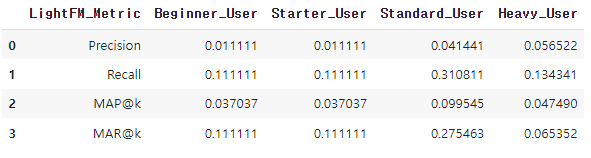

**user_type1**

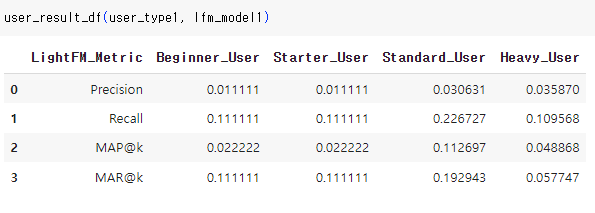

**user_type2**

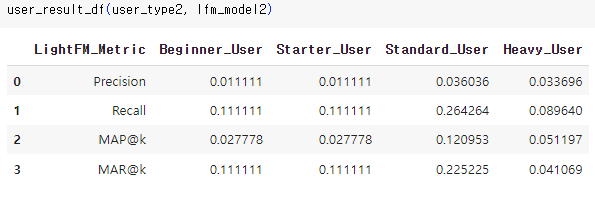

**user_type3**

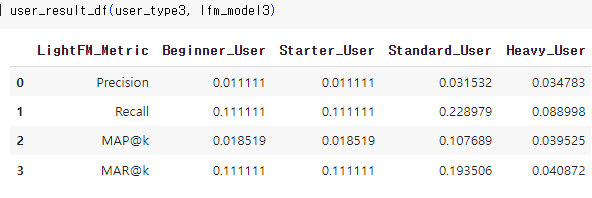

In [ ]:
# 유저별 결과 확인하는 함수
def user_result_df(user_type,lfm_model2):

  beginner_user = user_type[user_type['type_name']=="Beginner"]
  starter_user = user_type[user_type['type_name']=="Starter"]
  standard_user = user_type[user_type['type_name']=="Standard"]
  heavy_user = user_type[user_type['type_name']=="Heavy"]

  user_type = user_type.drop('type_name', axis=1)
  user_metrics_df = pd.DataFrame(lfm_model2.user_metrics)

  beginner_user_results = user_metrics_df[user_metrics_df['subsr_id'].isin(beginner_user['subsr_id'])]
  starter_user_results = user_metrics_df[user_metrics_df['subsr_id'].isin(starter_user['subsr_id'])]
  standard_user_results = user_metrics_df[user_metrics_df['subsr_id'].isin(standard_user['subsr_id'])]
  heavy_user_results = user_metrics_df[user_metrics_df['subsr_id'].isin(heavy_user['subsr_id'])]

  # Heavy (시청 비율이 75% 이상)
  h_overall_precision = heavy_user_results['precision'].mean()
  h_overall_recall = heavy_user_results['recall'].mean()
  h_overall_map_at_k = heavy_user_results['map_at_k'].mean()
  h_overall_mar_at_k = heavy_user_results['mar_at_k'].mean()

  #Standard (시청 비율이 25~75%)
  s_overall_precision = standard_user_results['precision'].mean()
  s_overall_recall = standard_user_results['recall'].mean()
  s_overall_map_at_k = standard_user_results['map_at_k'].mean()
  s_overall_mar_at_k = standard_user_results['mar_at_k'].mean()

  #Standard (시청 비율이 25% 이하)
  st_overall_precision = starter_user_results['precision'].mean()
  st_overall_recall = starter_user_results['recall'].mean()
  st_overall_map_at_k = starter_user_results['map_at_k'].mean()
  st_overall_mar_at_k = starter_user_results['mar_at_k'].mean()

  #Beginner (Cold_starter -> 시청기록이 아예 없는 유저)
  b_overall_precision = beginner_user_results['precision'].mean()
  b_overall_recall = beginner_user_results['recall'].mean()
  b_overall_map_at_k = beginner_user_results['map_at_k'].mean()
  b_overall_mar_at_k = beginner_user_results['mar_at_k'].mean()

  summary_df = pd.DataFrame({
      'LightFM_Metric': ['Precision', 'Recall', 'MAP@k', 'MAR@k'],
      "Beginner_User" : [st_overall_precision, st_overall_recall, st_overall_map_at_k, st_overall_mar_at_k],
      'Starter_User': [st_overall_precision, st_overall_recall, st_overall_map_at_k, st_overall_mar_at_k],
      'Standard_User': [s_overall_precision, s_overall_recall, s_overall_map_at_k, s_overall_mar_at_k],
      'Heavy_User': [h_overall_precision, h_overall_recall, h_overall_map_at_k, h_overall_mar_at_k]
  })

  # summary_df.to_csv("/content/drive/MyDrive/dxdata/result_by_user")
  return summary_df

In [ ]:
# 결과 확인 용도
user_type1 = combined_df_filled.copy() # 0.2 이상인 컬럼
user_type2 = combined_df_filled2.copy() # 0.3 이상인 컬럼
user_type3 = combined_df_filled3.copy() # 0.5 이상인 컬럼

# 모델 입력용도
user_type_1 = user_type.drop('type_name', axis=1)
user_type_2 = user_type2.drop('type_name', axis=1)
user_type_3 = user_type3.drop('type_name', axis=1)

In [ ]:
user_result_df(user_type, lfm_model)

,LightFM_Metric,Beginner_User,Starter_User,Standard_User,Heavy_User
0,Precision,0.011111,0.011111,0.041441,0.056522
1,Recall,0.111111,0.111111,0.310811,0.134341
2,MAP@k,0.037037,0.037037,0.099545,0.047490
3,MAR@k,0.111111,0.111111,0.275463,0.065352


In [ ]:
user_result_df(user_type1, lfm_model1)

,LightFM_Metric,Beginner_User,Starter_User,Standard_User,Heavy_User
0,Precision,0.011111,0.011111,0.030631,0.035870
1,Recall,0.111111,0.111111,0.226727,0.109568
2,MAP@k,0.022222,0.022222,0.112697,0.048868
3,MAR@k,0.111111,0.111111,0.192943,0.057747


In [ ]:
user_result_df(user_type2, lfm_model2)

,LightFM_Metric,Beginner_User,Starter_User,Standard_User,Heavy_User
0,Precision,0.011111,0.011111,0.036036,0.033696
1,Recall,0.111111,0.111111,0.264264,0.089640
2,MAP@k,0.027778,0.027778,0.120953,0.051197
3,MAR@k,0.111111,0.111111,0.225225,0.041069


In [ ]:
user_result_df(user_type3, lfm_model3)

,LightFM_Metric,Beginner_User,Starter_User,Standard_User,Heavy_User
0,Precision,0.011111,0.011111,0.031532,0.034783
1,Recall,0.111111,0.111111,0.228979,0.088998
2,MAP@k,0.018519,0.018519,0.107689,0.039525
3,MAR@k,0.111111,0.111111,0.193506,0.040872


In [ ]:
user_result_df(user_type, genre_model)

,LightFM_Metric,Beginner_User,Starter_User,Standard_User,Heavy_User
0,Precision,NaN,NaN,0.007778,0.014286
1,Recall,NaN,NaN,0.048148,0.048157
2,MAP@k,NaN,NaN,0.039074,0.022645
3,MAR@k,NaN,NaN,0.037346,0.033272
